In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from IPython.display import clear_output

%run utils/utils_data_cleaning.py

#### Load data

In [2]:
n_chunks = 1
chunks = [pkl.load(open('../data/bin_chunks/ttd_chunk_{0}.pkl'.format(i), 'rb')) for i in range(1, n_chunks + 1)]
dataset = pd.concat(chunks)
dataset.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


#### Note

Intuitively, the distance traveled by a taxi is highly important when trying to estimate the duration of the trip. Hence, the trip distance is probably a good feature to input into our model. 

Although the dataset provides us with the *actual* distance the taxi traveled, we should not expect that to be an input, since usually it is not available in practice: there is no certainty about which way the taxi driver will be taking.

However, pickup and dropoff information allows us to establish the **vector distance** between the two points. From that, we might be able to estimate the actual **trip distance** with some accuracy.

This notebook is focused on exploring the relationship between those two distances, aiming for a good mapping between them.

Let's refresh the plot previously shown in the *_spatial_analysis* notebook.

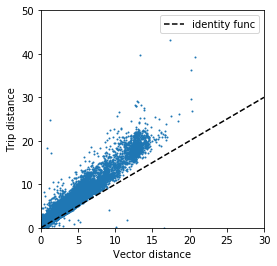

In [3]:
fig = plt.figure(figsize=(4,4))
plt.scatter(dataset.vec_dist, dataset.trip_dist, s = 1, label=None)
plt.plot((0,30),(0,30), '--', c='k', label='identity func')
plt.xlabel('Vector distance')
plt.ylabel('Trip distance')
plt.legend()
plt.xlim((0,30))
plt.ylim((0,50))
plt.show()

As expected, the plot show us that the trip distance tends to be higher than the vector distance. 

## 1. Linear Model

$ tripDistance = f(vecDistance) = m \cdot vecDistance + n$

It is safe to set $n = 0$, since a zero vector distance (pickup == dropoff) should yield a zero trip distance. 


The simple model to fit a straight line, i.e. to assume that $\frac{tripDistance}{vecDistance}$ is a constant value $m$. 

In order to be more robust to outliers/noise, let's take $m$ as the **median** of the data.

In [4]:
m1,m2 = dataset.trip_ratio.mean(), dataset.trip_ratio.median()

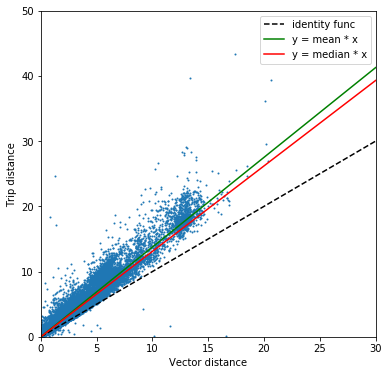

In [5]:
fig = plt.figure(figsize=(6,6))
plt.scatter(dataset.vec_dist, dataset.trip_dist, s = 1, label=None)
plt.plot((0,30),(0,30), '--', c='k', label='identity func')
plt.plot((0,30),(0,30*m1),  c='g', label='y = mean * x')
plt.plot((0,30),(0,30*m2), c='r', label='y = median * x')
plt.xlabel('Vector distance')
plt.ylabel('Trip distance')
plt.legend()
plt.xlim((0,30))
plt.ylim((0,50))
plt.show()

## 2. Grid-based model 

In [6]:
%run utils/utils_line_supercover.py

### Using various grid sizes

In [7]:
gMap_20 = GridMap(size=(20,20), bbox = (LAT_NORTH, LAT_SOUTH, LON_EAST, LON_WEST))
gMap_40 = GridMap(size=(40,40), bbox = (LAT_NORTH, LAT_SOUTH, LON_EAST, LON_WEST))
gMap_100 = GridMap(size=(100,100), bbox = (LAT_NORTH, LAT_SOUTH, LON_EAST, LON_WEST))

#### Example

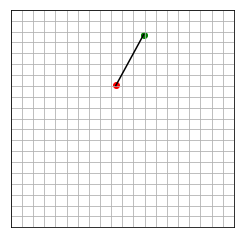

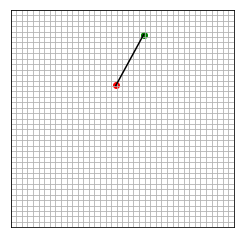

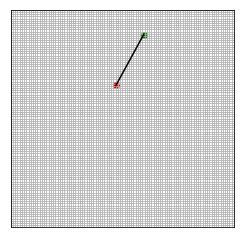

In [8]:
sample = dataset.iloc[0]
pu = np.array([sample.pu_lon, sample.pu_lat])
do = np.array([sample.do_lon, sample.do_lat])

gMap_20.plot_path(pu, do, show_cells=True )
gMap_40.plot_path(pu, do)
gMap_100.plot_path(pu, do)

#### Fit data to grid 

In [9]:
median_map_20 = gMap_20.fitGrid(dataset, func='median')
median_map_40 = gMap_40.fitGrid(dataset, func='median')
median_map_100 = gMap_100.fitGrid(dataset, func='median')

In [10]:
# Generating vector of medians for histogram plot
median_vec_20  =  median_map_20[~np.isnan( median_map_20)]
median_vec_40  =  median_map_40[~np.isnan( median_map_40)]
median_vec_100 = median_map_100[~np.isnan(median_map_100)]

#### Plotting

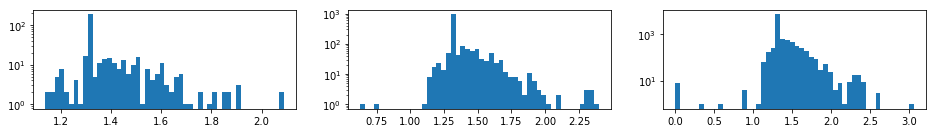

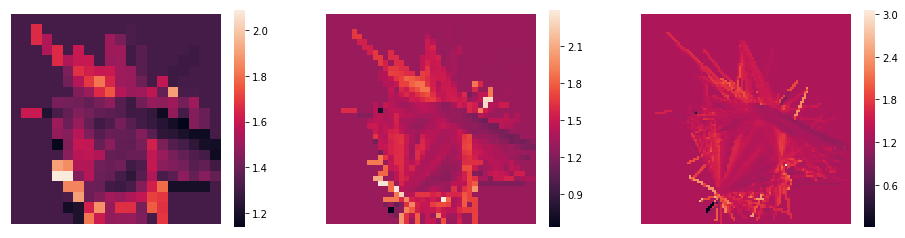

In [11]:
plt.figure(figsize=(16,4))
plt.subplot(2,3,1)
plt.hist(median_vec_20, bins=50, log=True)
plt.subplot(2,3,2)
plt.hist(median_vec_40, bins=50, log=True)
plt.subplot(2,3,3)
plt.hist(median_vec_100, bins=50, log=True)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.heatmap(median_map_20, xticklabels=False, yticklabels=False,square=True)
plt.subplot(1,3,2)
sns.heatmap(median_map_40, xticklabels=False, yticklabels=False,square=True)
plt.subplot(1,3,3)
sns.heatmap(median_map_100, xticklabels=False, yticklabels=False,square=True)

plt.show()

#### Predicting 

In [15]:
gMap_20.predictFactor(dataset).head()

0    1.197873
1    1.299787
2    1.304626
3    1.299787
4    1.301696
dtype: float64